In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



This will allow me to print the correct decay equation. All we need is the correct decay constant from Bayes. Also, don't revert notebooks
The question is, how do we model multiple decays? The decay constants will form a Normal distibution under Bayes treatment. Can start each thermal decay curve at zero, then add all the data sets. This will yield a decay rate for the whole set, which can be refit to each curve with starting point. 

This can be checked by comparing to each individual decay constant and average constants. 

## Find decay constant with Bayes regression, using one data set


In [10]:
#Read data into dataframe 
df1 = pd.read_csv('../data/2014.12.17 OneHalf in Si post', header=None , names = ['Time', 'Temp'],  delimiter = '\t')

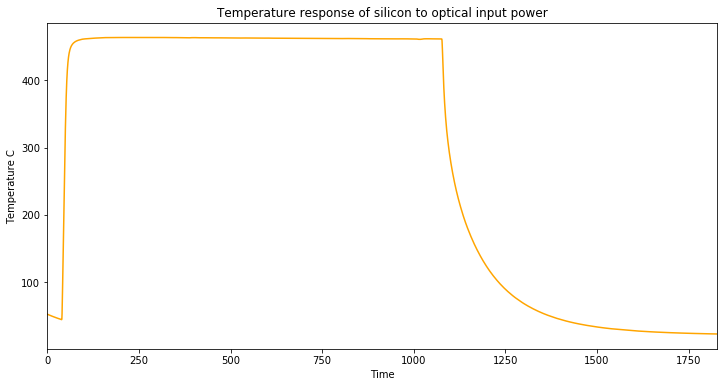

In [11]:
#Plotting Temperature response as a function of time 
df1.plot(x = 'Time', y = 'Temp', color = 'orange', legend = False, figsize=(12, 6))
plt.title("Temperature response of silicon to optical input power")
plt.ylabel("Temperature C",);

From the plot above, we see that the power source was turned on sometime after 200 seconds. The sample reached steady state temperature at about 900 s, with a T ~ 250 C. After ~900 s the input optical power source is turned off; and the temperature decays back down to room temperature. This decay is a function of the materials emissivity. 

In [12]:
#Find room temperature 
T0 = df1.Temp.min()
T0

23.008000000000003

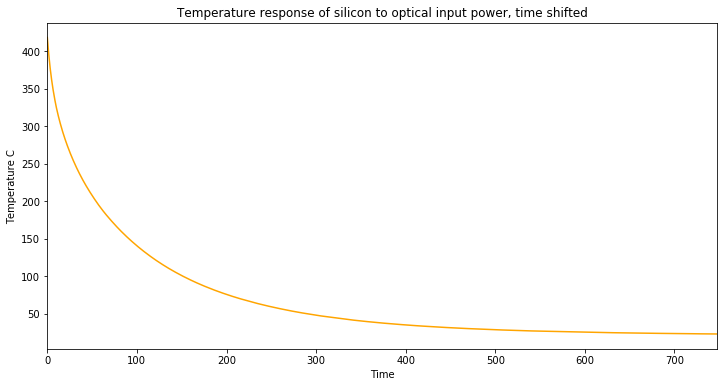

In [13]:
#Next we need to isolate the thermal decay region 
df1 = df1[ (df1.Time > 1000) & (df1.Temp < 420)]
df1.Time -= df1.Time.min() #sets decay start time to zero 
df1.plot(x = 'Time', y = 'Temp', color = 'orange', legend = False, figsize=(12, 6))
plt.title("Temperature response of silicon to optical input power, time shifted")
plt.ylabel("Temperature C",);

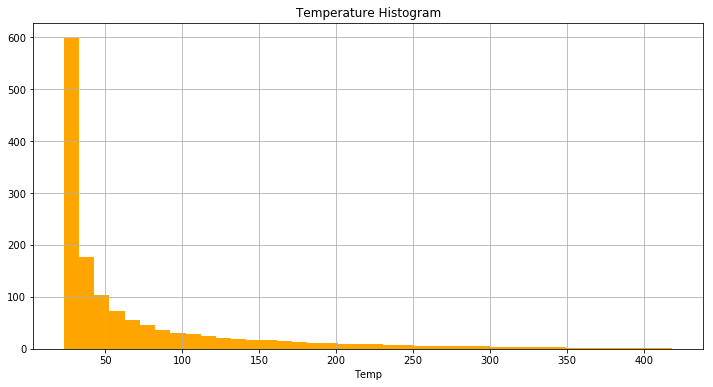

In [14]:
#Plot histogram of data
df1.Temp.hist(color='orange', figsize=(12,6), bins=40)
plt.title("Temperature Histogram")
plt.xlabel("Temp");

The histogram above hints that we should use an exponential decay probability density function. D ~ Exp(c_decay) for data and  c_decay ~ Nomal(0,1) for prior. 

100%|██████████| 5500/5500 [00:03<00:00, 1422.01it/s]



c_decay:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.014            0.000            0.000            [0.014, 0.015]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.014          0.014          0.014          0.015          0.015



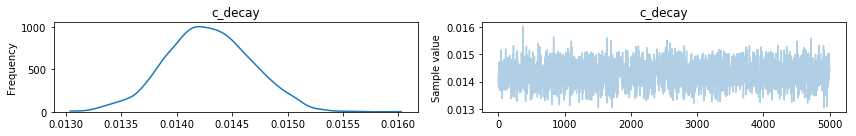

In [15]:
#Invoking Bayes statistics to find the decay contsant of thermal decay data 
with pm.Model():
    # Prior 
    c_decay = pm.Uniform('c_decay', 0, 1) #model constant uniform distribution 
     
    # likelihood  
    data1 = np.array(df1.Temp) #convert data frame to array
    data_fit = pm.Exponential('data_fit', lam = c_decay, observed=data1) 

    # Inference
    #start = find_MAP( ) # Find starting value by optimization
    step = pm.NUTS() # Instantiate MCMC sampling algorithm
    trace = pm.sample(5000, step, tune=500)
    pm.summary(trace)
    pm.traceplot(trace)

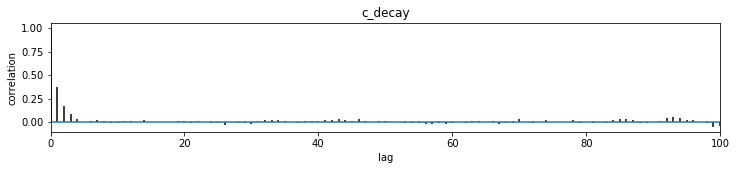

In [8]:
pm.plots.autocorrplot(trace);

Now we can simulate a curve this decay constant and plot it against data. 

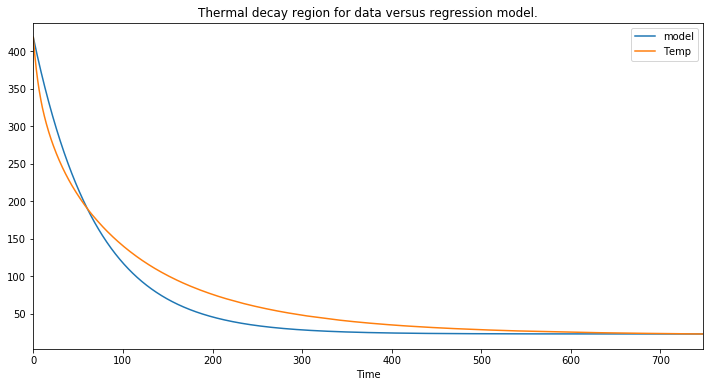

In [16]:
lam_1 = trace['c_decay'].mean()
a = df1.Temp.max() - T0 #Value at t = 0 
df1['model'] = a*np.exp(-(lam_1)*( df1['Time'] )) + T0
df1.plot(x = 'Time', y = ['model', 'Temp'], figsize=(12, 6), title = 'Thermal decay region for data versus regression model.');

In [17]:
lam_1

0.014289376012834139

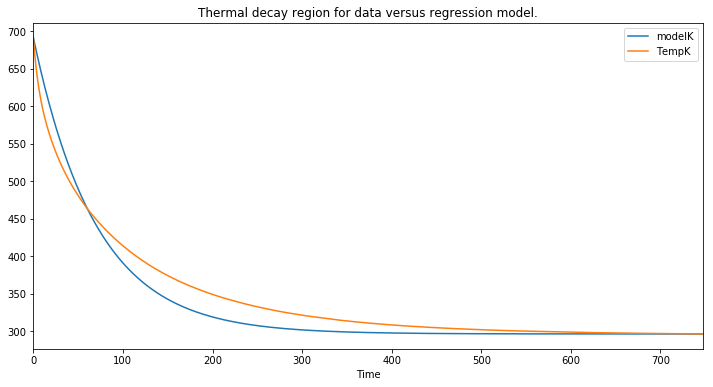

In [18]:
#Convert Temp to Kelvin and replotting curve
df1['TempK'] = df1.Temp + 273.15  
T0K = T0 + 273.15
lam_1 = trace['c_decay'].mean()
aK = df1.TempK.max() - T0K #Value at t = 0 
df1['modelK'] = aK*np.exp(-(lam_1)*( df1['Time'] )) + T0K
df1.plot(x = 'Time', y = ['modelK', 'TempK'], figsize=(12, 6), title = 'Thermal decay region for data versus regression model.');

Using thermal balance equations we can plot emissivity as a function of temperature. 

In [17]:
T0K


296.15799999999996